In [6]:
# Import the packages
import pandas as pd
from google.cloud import bigquery
from google.cloud import bigquery_storage
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Declare some global inputs
test_names = ["AE_20230616_R_BZ_P_RAK-LoveBrands"]
lb_pipeline_run_date = "2023-07-06"
test_start_date = "2023-06-19"
asa_ids = ["35"]
entity_id = "TB_AE"
lb_designated_tg = "Target Group 1" # Depending on whether or not there are conditions in the test, the Loved Brands can be in other target groups different from TG1
nlb_designated_tg = "Target Group 2" # Depending on whether or not there are conditions in the test, the non-Loved Brands can be in other target groups different from TG2
ela_var = "Variation1" # Elasticity variant in the test
num_bootstrap_samples = 1000 # Number of data points to have on the histogram
cl = 0.95
left_threshold = round((1 - cl) / 2, 4)
right_threshold = round((1 - (1 - cl) / 2), 4)

# Create a data frame combining the test name with the targeted ASA
df_test_asa = pd.DataFrame({"test_name": test_names, "asa_id_of_test": asa_ids})

In [8]:
# Instantiate the BQ client
client = bigquery.Client(project="logistics-customer-staging")
bqstorage_client = bigquery_storage.BigQueryReadClient()

g:\My Drive\APAC\venv_dh\lib\site-packages\google\auth\_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [5]:
# Query the test data and join the resulting data frame with df_test_asa
df_test_data = client.query(
    query=f"""
        SELECT * FROM `logistics-data-storage-staging.long_term_pricing.ab_test_individual_orders_cleaned_lb_rollout_tests`
        WHERE test_name IN ('{"', '".join(test_names)}') AND created_date_utc >= DATE("{test_start_date}")
    """
).result().to_dataframe(bqstorage_client=bqstorage_client, progress_bar_type="tqdm")

df_test_data = pd.merge(left=df_test_data, right=df_test_asa, how="left", on="test_name")

Downloading: 100%|██████████|


In [9]:
# Query the Loved Brands based on the last pipeline run
df_lb_pipeline = client.query(
    query=f"""
        SELECT * FROM `logistics-data-storage-staging.long_term_pricing.final_vendor_list_all_data_loved_brands_scaled_code`
        WHERE TRUE
            AND DATE(update_timestamp) = DATE("{lb_pipeline_run_date}")
            AND asa_id IN ({', '.join(asa_ids)})
            AND entity_id = "{entity_id}"
    """
).result().to_dataframe(bqstorage_client=bqstorage_client, progress_bar_type="tqdm")

Downloading: 100%|██████████|


In [10]:
# Create three data frames for simple LBs, full LBs and non-LBs
common_cols = [
    "region",
    "entity_id",
    "country_code",
    "asa_id",
    "master_asa_id",
    "asa_name",
    "asa_common_name",
    "vendor_code",
    "vertical_type",
    "vendor_rank_lm",
    "is_lb_lm",
]

simple_lbs = df_lb_pipeline[df_lb_pipeline["vendor_rank_lm"] == "Top 25%"][common_cols]
full_lbs = df_lb_pipeline[df_lb_pipeline["is_lb_lm"] == "Y"][common_cols]
non_lbs = df_lb_pipeline[(df_lb_pipeline["is_lb_lm"] == "N")][common_cols]

In [11]:
# Display the number of vendors per ASA ID for each of the data frames created above
print("The number of simple Loved Brands per ASA...")
display(simple_lbs.groupby(["entity_id", "asa_id", "is_lb_lm"])["vendor_code"].count().to_frame().reset_index())

print("\nThe number of full Loved Brands per ASA...")
display(full_lbs.groupby(["entity_id", "asa_id", "is_lb_lm"])["vendor_code"].count().to_frame().reset_index())

print("\nThe number of non-Loved Brands per ASA...")
display(non_lbs.groupby(["entity_id", "asa_id", "is_lb_lm"])["vendor_code"].count().to_frame().reset_index())

The number of simple Loved Brands per ASA...


,entity_id,asa_id,is_lb_lm,vendor_code
0,TB_AE,35,N,36
1,TB_AE,35,Y,42



The number of full Loved Brands per ASA...


,entity_id,asa_id,is_lb_lm,vendor_code
0,TB_AE,35,Y,42



The number of non-Loved Brands per ASA...


,entity_id,asa_id,is_lb_lm,vendor_code
0,TB_AE,35,N,499


In [12]:
# Run the bootstrapping function sequentially
vendor_labels = ["simple_lbs", "full_lbs", "non_lbs"]
df_sim_results = []
sim_counter = 1
for i in test_names:
    for j in vendor_labels:
        # Filter the data based on the test
        df_sub_test = df_test_data[df_test_data["test_name"] == i]

        # Filter the simple LBs data frame to the right set of vendors based on the ASA ID that belong to the test
        relevant_simple_lbs = simple_lbs[simple_lbs["asa_id"] == int(df_sub_test["asa_id_of_test"].unique()[0])]
        
        # Further filter the data based on the vendor labels
        if j == "full_lbs":
            df_sub_test = df_sub_test[df_sub_test["target_group_bi"] == lb_designated_tg]
        elif j == "non_lbs":
            df_sub_test = df_sub_test[df_sub_test["target_group_bi"] == nlb_designated_tg]
        else:
            df_sub_test = df_sub_test[df_sub_test["vendor_id"].isin(relevant_simple_lbs["vendor_code"])]
        
        # Elasticity calculated by pct difference in no. of transactions / pct difference in average DF
        for k in range(1, num_bootstrap_samples + 1):
            print(f"Iteration {sim_counter}. Sampling with the following parameters --> test_name: {i}, vendor_group_label: {j}, sample_num: {k}")
            df_ctl_sample = df_sub_test[df_sub_test["variant"] == "Control"].sample(frac=1, replace=True)
            df_var_sample = df_sub_test[df_sub_test["variant"] == ela_var].sample(frac=1, replace=True)

            num_orders_ctl = df_ctl_sample["platform_order_code"].nunique()
            num_orders_var = df_var_sample["platform_order_code"].nunique()

            avg_df_ctl = df_ctl_sample["delivery_fee_local"].sum() / num_orders_ctl
            avg_df_var = df_var_sample["delivery_fee_local"].sum() / num_orders_var

            pct_diff_orders = float((num_orders_var - num_orders_ctl) / num_orders_ctl)
            pct_diff_avg_df = float((avg_df_var - avg_df_ctl) / avg_df_ctl)

            elasticity = pct_diff_orders / pct_diff_avg_df

            output_dict = {
                "test_name": i,
                "vendor_group_label": j,
                "sample_num": k,
                "elasticity": elasticity,
                "pct_diff_orders": pct_diff_orders,
                "pct_diff_avg_df": pct_diff_avg_df,
            }

            df_sim_results.append(output_dict)
            
            # Increment the sim counter
            sim_counter += 1

df_sim_results = pd.DataFrame(df_sim_results)

Iteration 1. Sampling with the following parameters --> test_name: AE_20230616_R_BZ_P_RAK-LoveBrands, vendor_group_label: simple_lbs, sample_num: 1
Iteration 2. Sampling with the following parameters --> test_name: AE_20230616_R_BZ_P_RAK-LoveBrands, vendor_group_label: simple_lbs, sample_num: 2
Iteration 3. Sampling with the following parameters --> test_name: AE_20230616_R_BZ_P_RAK-LoveBrands, vendor_group_label: simple_lbs, sample_num: 3
Iteration 4. Sampling with the following parameters --> test_name: AE_20230616_R_BZ_P_RAK-LoveBrands, vendor_group_label: simple_lbs, sample_num: 4
Iteration 5. Sampling with the following parameters --> test_name: AE_20230616_R_BZ_P_RAK-LoveBrands, vendor_group_label: simple_lbs, sample_num: 5
Iteration 6. Sampling with the following parameters --> test_name: AE_20230616_R_BZ_P_RAK-LoveBrands, vendor_group_label: simple_lbs, sample_num: 6
Iteration 7. Sampling with the following parameters --> test_name: AE_20230616_R_BZ_P_RAK-LoveBrands, vendor_gro

In [13]:
# Calculate the mean elasticity of LBs, non-LBs, and simple LBs per test
def percentile_left(x):
    return x.quantile(left_threshold)

def percentile_right(x):
    return x.quantile(right_threshold)

list_of_agg_functions = ["mean", percentile_left, percentile_right]
agg_func_selection = {"elasticity": list_of_agg_functions, "pct_diff_orders": list_of_agg_functions, "pct_diff_avg_df": list_of_agg_functions}
df_stats = df_sim_results.groupby(["test_name", "vendor_group_label"])[["elasticity", "pct_diff_orders", "pct_diff_avg_df"]].agg(agg_func_selection).reset_index()
df_stats

test_name vendor_group_label elasticity  \
                                                              mean   
0  AE_20230616_R_BZ_P_RAK-LoveBrands           full_lbs   0.106120   
1  AE_20230616_R_BZ_P_RAK-LoveBrands            non_lbs   0.173776   
2  AE_20230616_R_BZ_P_RAK-LoveBrands         simple_lbs   0.371515   

                                   pct_diff_orders                  \
  percentile_left percentile_right            mean percentile_left   
0       -0.052818         0.336336        0.011047       -0.006994   
1       -0.004445         0.434785        0.017869       -0.000603   
2        0.203662         0.587120        0.033639        0.022249   

                   pct_diff_avg_df                                   
  percentile_right            mean percentile_left percentile_right  
0         0.031183        0.115250        0.083298         0.145509  
1         0.036955        0.110453        0.080594         0.143729  
2         0.045253        0.092765        0.073582         0.111412

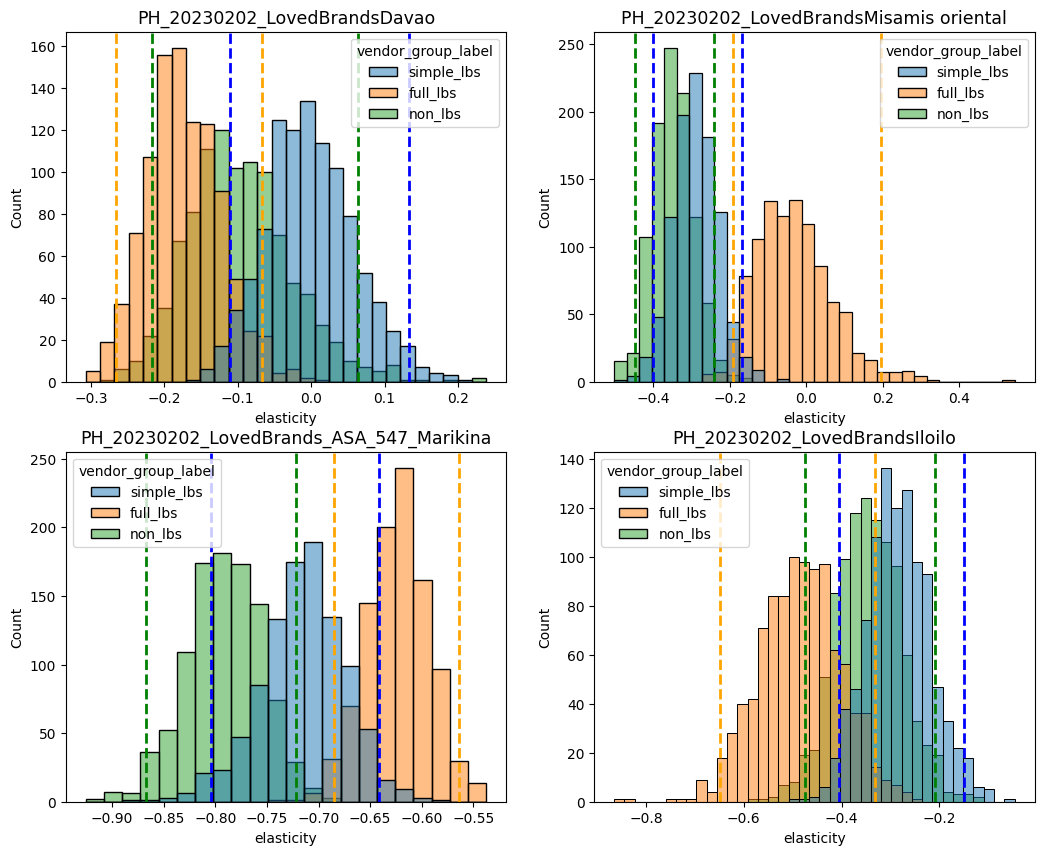

In [10]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12.5,10))
def plot_func(test_name, ax_x, ax_y):
    sns.histplot(data=df_sim_results[df_sim_results["test_name"] == test_name], x="elasticity", hue="vendor_group_label", ax=axes[ax_x, ax_y])
    percentile_left_flbs = df_stats[(df_stats["test_name"] == test_name) & (df_stats["vendor_group_label"] == "full_lbs")]\
        ["elasticity"].reset_index(drop=True)["percentile_left"][0]
    percentile_left_nlbs = df_stats[(df_stats["test_name"] == test_name) & (df_stats["vendor_group_label"] == "non_lbs")]["elasticity"]\
        .reset_index(drop=True)["percentile_left"][0]
    percentile_left_slbs = df_stats[(df_stats["test_name"] == test_name) & (df_stats["vendor_group_label"] == "simple_lbs")]["elasticity"]\
        .reset_index(drop=True)["percentile_left"][0]

    percentile_right_flbs = df_stats[(df_stats["test_name"] == test_name) & (df_stats["vendor_group_label"] == "full_lbs")]["elasticity"]\
        .reset_index(drop=True)["percentile_right"][0]
    percentile_right_nlbs = df_stats[(df_stats["test_name"] == test_name) & (df_stats["vendor_group_label"] == "non_lbs")]["elasticity"]\
        .reset_index(drop=True)["percentile_right"][0]
    percentile_right_slbs = df_stats[(df_stats["test_name"] == test_name) & (df_stats["vendor_group_label"] == "simple_lbs")]["elasticity"]\
        .reset_index(drop=True)["percentile_right"][0]

    axes[ax_x, ax_y].axvline(x = percentile_left_flbs, ymin=0, ymax=1, color = "orange", linestyle="--", linewidth=2)
    axes[ax_x, ax_y].axvline(x = percentile_left_nlbs, ymin=0, ymax=1, color = "green", linestyle="--", linewidth=2)
    axes[ax_x, ax_y].axvline(x = percentile_left_slbs, ymin=0, ymax=1, color = "blue", linestyle="--", linewidth=2)
    axes[ax_x, ax_y].axvline(x = percentile_right_flbs, ymin=0, ymax=1, color = "orange", linestyle="--", linewidth=2)
    axes[ax_x, ax_y].axvline(x = percentile_right_nlbs, ymin=0, ymax=1, color = "green", linestyle="--", linewidth=2)
    axes[ax_x, ax_y].axvline(x = percentile_right_slbs, ymin=0, ymax=1, color = "blue", linestyle="--", linewidth=2)
    axes[ax_x, ax_y].set_title(test_name, size = 12.5)

# Plot the graphs by looping over all tests
for idx, tst in enumerate(test_names):
    if idx == 0:
        ax_x = 0
        ax_y = 0
    elif idx == 1:
        ax_x = 0
        ax_y = 1
    elif idx == 2:
        ax_x = 1
        ax_y = 0
    if idx == 3:
        ax_x = 1
        ax_y = 1
    plot_func(test_name=tst, ax_x=ax_x, ax_y=ax_y)

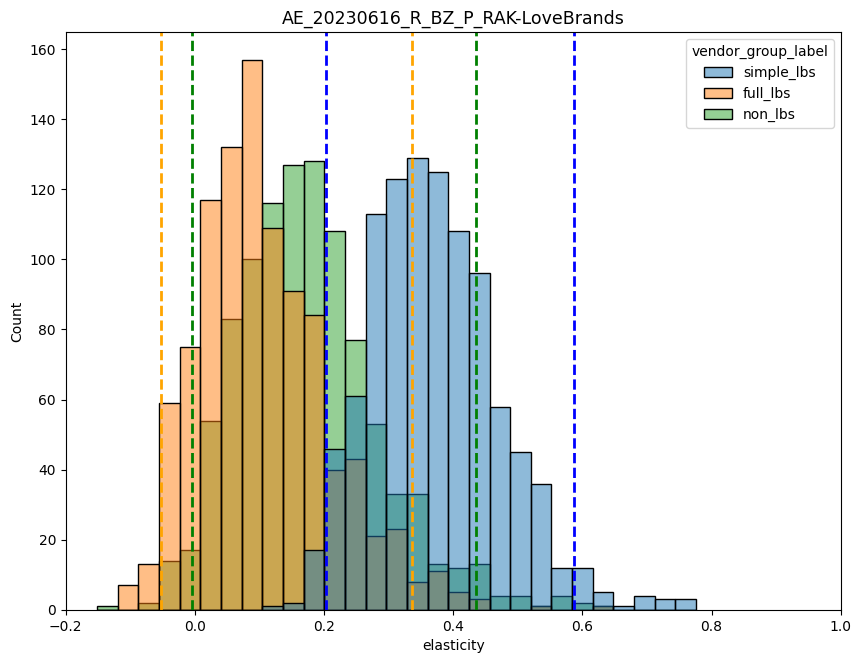

In [16]:
fig, axes = plt.subplots(figsize = (10,7.5))
def plot_func_single(test_name):
    sns.histplot(data=df_sim_results[df_sim_results["test_name"] == test_name], x="elasticity", hue="vendor_group_label")
    percentile_left_flbs = df_stats[(df_stats["test_name"] == test_name) & (df_stats["vendor_group_label"] == "full_lbs")]\
        ["elasticity"].reset_index(drop=True)["percentile_left"][0]
    percentile_left_nlbs = df_stats[(df_stats["test_name"] == test_name) & (df_stats["vendor_group_label"] == "non_lbs")]["elasticity"]\
        .reset_index(drop=True)["percentile_left"][0]
    percentile_left_slbs = df_stats[(df_stats["test_name"] == test_name) & (df_stats["vendor_group_label"] == "simple_lbs")]["elasticity"]\
        .reset_index(drop=True)["percentile_left"][0]

    percentile_right_flbs = df_stats[(df_stats["test_name"] == test_name) & (df_stats["vendor_group_label"] == "full_lbs")]["elasticity"]\
        .reset_index(drop=True)["percentile_right"][0]
    percentile_right_nlbs = df_stats[(df_stats["test_name"] == test_name) & (df_stats["vendor_group_label"] == "non_lbs")]["elasticity"]\
        .reset_index(drop=True)["percentile_right"][0]
    percentile_right_slbs = df_stats[(df_stats["test_name"] == test_name) & (df_stats["vendor_group_label"] == "simple_lbs")]["elasticity"]\
        .reset_index(drop=True)["percentile_right"][0]

    axes.axvline(x = percentile_left_flbs, ymin=0, ymax=1, color = "orange", linestyle="--", linewidth=2)
    axes.axvline(x = percentile_left_nlbs, ymin=0, ymax=1, color = "green", linestyle="--", linewidth=2)
    axes.axvline(x = percentile_left_slbs, ymin=0, ymax=1, color = "blue", linestyle="--", linewidth=2)
    axes.axvline(x = percentile_right_flbs, ymin=0, ymax=1, color = "orange", linestyle="--", linewidth=2)
    axes.axvline(x = percentile_right_nlbs, ymin=0, ymax=1, color = "green", linestyle="--", linewidth=2)
    axes.axvline(x = percentile_right_slbs, ymin=0, ymax=1, color = "blue", linestyle="--", linewidth=2)
    axes.set_xlim((-0.2,1))
    axes.set_title(test_name, size = 12.5)

# Plot the graph
plot_func_single(test_name="AE_20230616_R_BZ_P_RAK-LoveBrands")
# plot_func_single(test_name="TH_20230616_LBs_Khon kaen_ASA ID 2028_New Wave")
# plot_func_single(test_name="TH_20230331_LBs_NST_ASA ID 1098_New Wave")

In [ ]:
# Run the bootstrapping function sequentially
df_kpi_sim_results = []
sim_counter = 1
for i in test_names:
    # Filter the data based on the test
    df_sub_test = df_test_data[df_test_data["test_name"] == i]

    # Further filter the data based on the vendor labels
    df_sub_test = df_sub_test[df_sub_test["target_group_bi"].isin(["Target Group 1", "Target Group 2"])]
    
    # Elasticity calculated by pct difference in no. of transactions / pct difference in average DF
    for k in range(1, num_bootstrap_samples + 1):
        print(f"Iteration {sim_counter}. Sampling with the following parameters --> test_name: {i}, vendor_group_label: {j}, sample_num: {k}")
        df_ctl_sample = df_sub_test[df_sub_test["variant"] == "Control"].sample(frac=1, replace=True)
        df_var_sample = df_sub_test[df_sub_test["variant"] == "Variation3"].sample(frac=1, replace=True)

        num_customers_ctl = df_ctl_sample["perseus_client_id"].nunique()
        num_customers_var = df_var_sample["perseus_client_id"].nunique()

        gp_per_customer_ctl = df_ctl_sample["gross_profit_local"].sum() / num_customers_ctl
        gp_per_customer_var = df_var_sample["gross_profit_local"].sum() / num_customers_var

        output_dict = {
            "test_name": i,
            "sample_num": k,
            "gp_per_customer_ctl": gp_per_customer_ctl,
            "gp_per_customer_var": gp_per_customer_var,
        }

        df_kpi_sim_results.append(output_dict)
        
        # Increment the sim counter
        sim_counter += 1

df_kpi_sim_results = pd.DataFrame(df_kpi_sim_results)

In [22]:
# Calculate the mean gp_per_customer
list_of_agg_functions = ["mean", percentile_left, percentile_right]
agg_func_selection = {"gp_per_customer_ctl": list_of_agg_functions, "gp_per_customer_var": list_of_agg_functions}
df_kpi_stats = df_kpi_sim_results.groupby(["test_name"])[["gp_per_customer_ctl", "gp_per_customer_var"]].agg(agg_func_selection).reset_index()
df_kpi_stats

test_name gp_per_customer_ctl  \
                                                                   mean   
0        TH_20230317_LovedBrands_Bangkok_ASA ID 438           86.019056   
1          TH_20230331_LBs_NST_ASA ID 1098_New Wave          107.834237   
2  TH_20230331_LBs_Samut Sakhon_ASA ID 795_New Wave          136.204937   

                                   gp_per_customer_var                  \
  percentile_left percentile_right                mean percentile_left   
0       83.313901        88.597563           88.297286       85.403468   
1      104.750553       110.980662           89.618969       86.906906   
2      132.109202       140.303279          134.851735      130.933555   

                    
  percentile_right  
0        91.310649  
1        92.584613  
2       138.594223

In [33]:
df_kpi_stats[(df_kpi_stats["test_name"] == "TH_20230331_LBs_Samut Sakhon_ASA ID 795_New Wave")]\
        ["gp_per_customer_var"].reset_index(drop=True)["percentile_left"][0]

130.93355497685076

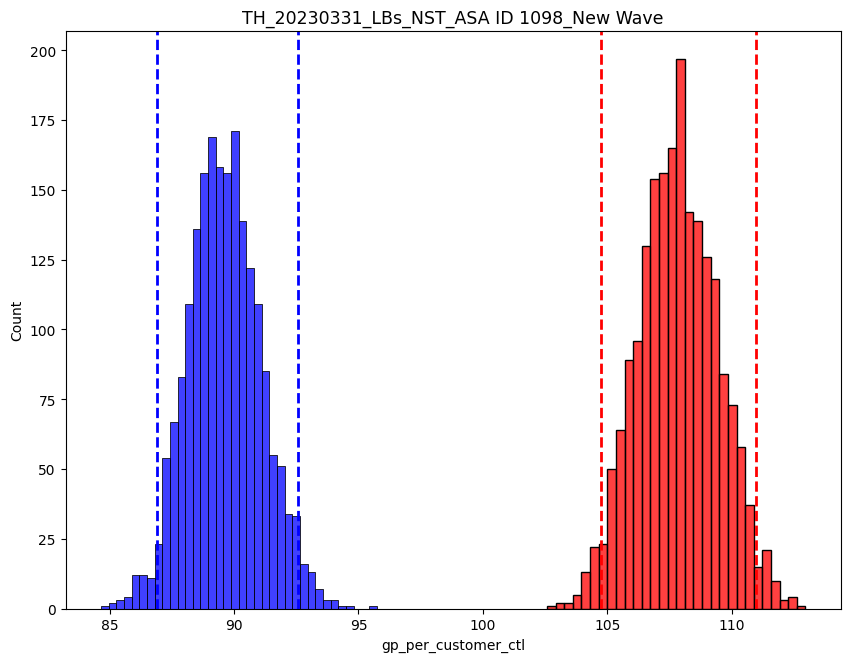

In [45]:
fig, axes = plt.subplots(figsize = (10,7.5))
def plot_func_kpi_single(test_name):
    sns.histplot(data=df_kpi_sim_results[df_kpi_sim_results["test_name"] == test_name], x="gp_per_customer_ctl", color="red")
    sns.histplot(data=df_kpi_sim_results[df_kpi_sim_results["test_name"] == test_name], x="gp_per_customer_var", color="blue")
    percentile_left_ctl = df_kpi_stats[(df_kpi_stats["test_name"] == test_name)]\
        ["gp_per_customer_ctl"].reset_index(drop=True)["percentile_left"][0]
    percentile_left_var = df_kpi_stats[(df_kpi_stats["test_name"] == test_name)]\
        ["gp_per_customer_var"].reset_index(drop=True)["percentile_left"][0]

    percentile_right_ctl = df_kpi_stats[(df_kpi_stats["test_name"] == test_name)]\
        ["gp_per_customer_ctl"].reset_index(drop=True)["percentile_right"][0]
    percentile_right_var = df_kpi_stats[(df_kpi_stats["test_name"] == test_name)]\
        ["gp_per_customer_var"].reset_index(drop=True)["percentile_right"][0]

    axes.axvline(x = percentile_left_ctl, ymin=0, ymax=1, color = "red", linestyle="--", linewidth=2)
    axes.axvline(x = percentile_left_var, ymin=0, ymax=1, color = "blue", linestyle="--", linewidth=2)
    axes.axvline(x = percentile_right_ctl, ymin=0, ymax=1, color = "red", linestyle="--", linewidth=2)
    axes.axvline(x = percentile_right_var, ymin=0, ymax=1, color = "blue", linestyle="--", linewidth=2)
    axes.set_title(test_name, size = 12.5)

# Plot the graph
# plot_func_kpi_single(test_name="TH_20230317_LovedBrands_Bangkok_ASA ID 438")
# plot_func_kpi_single(test_name="TH_20230331_LBs_Samut Sakhon_ASA ID 795_New Wave")
plot_func_kpi_single(test_name="TH_20230331_LBs_NST_ASA ID 1098_New Wave")